In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pickle


In [2]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
print(train.shape, test.shape)
train.head()

(8523, 12) (5681, 11)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
train['source'] = 'train'
test['source'] = 'test'

data = pd.concat([train, test], ignore_index=True)
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train


In [4]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

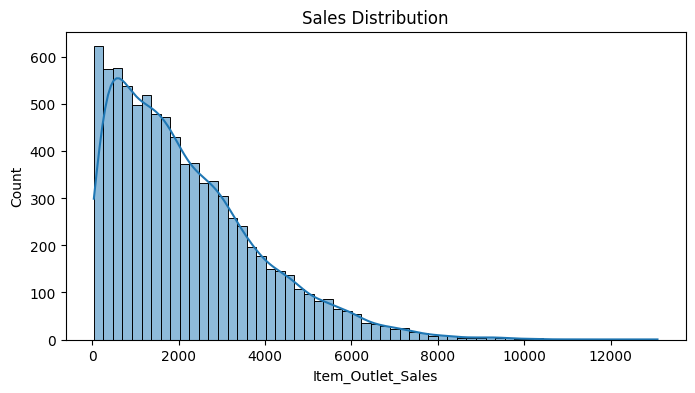

In [5]:
plt.figure(figsize=(8,4))
sns.histplot(train['Item_Outlet_Sales'], kde=True)
plt.title("Sales Distribution")
plt.show()

In [6]:
data['Item_Fat_Content'].replace({
    'LF': 'LOW Fat',
    'low fat': 'Low Fat',
    'reg': 'Regular'
}, inplace=True)

In [7]:
data['Item_Weight'] = data['Item_Weight'].fillna(data['Item_Weight'].mean())

In [8]:
data['Item_Visibility'] = data['Item_Visibility'].replace(0, np.nan)
data['Item_Visibility'] = data['Item_Visibility'].fillna(data['Item_Visibility'].mean())

data['Outlet_Size'] = data['Outlet_Size'].fillna(data['Outlet_Size'].mode()[0])

In [9]:
data['Item_Category'] = data['Item_Identifier'].apply(lambda x: x[:2])

In [10]:
data['Price_per_Weight'] = data['Item_MRP'] / data['Item_Weight']
data['Visibility_Ration'] = data['Item_Visibility'] / data.groupby('Item_Identifier')['Item_Visibility'].transform('mean')

In [11]:
data['Outlet_Age'] = 2025 - data['Outlet_Establishment_Year']

In [18]:
le = LabelEncoder()
cols = ['Item_Identifier','Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
        'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Category']
for c in cols:
    data[c] = le.fit_transform(data[c])

In [19]:
train = data[data['source'] == 'train']
test = data[data['source'] == 'test']

X = train.drop(['Item_Outlet_Sales', 'source'], axis=1)
y = train['Item_Outlet_Sales']

X_test_final = test.drop(['Item_Outlet_Sales', 'source'], axis=1)

In [20]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [21]:
X_train.dtypes

Item_Identifier                int32
Item_Weight                  float64
Item_Fat_Content               int64
Item_Visibility              float64
Item_Type                      int64
Item_MRP                     float64
Outlet_Identifier              int64
Outlet_Establishment_Year      int64
Outlet_Size                    int64
Outlet_Location_Type           int64
Outlet_Type                    int64
Item_Category                  int64
Price_per_Weight             float64
Visibility_Ration            float64
Outlet_Age                     int64
dtype: object

In [22]:
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_val)
rmse_rf = np.sqrt(mean_squared_error(y_val, pred_rf))
rmse_rf


1082.5667837651297

In [23]:
xgb = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_val)
rmse_xgb = np.sqrt(mean_squared_error(y_val, pred_xgb))
rmse_xgb

1139.8544573787053

In [24]:
print("Random Forest RMSE:", rmse_rf)
print("XGBoost RMSE:", rmse_xgb)

Random Forest RMSE: 1082.5667837651297
XGBoost RMSE: 1139.8544573787053


In [25]:
final_model = XGBRegressor(
    n_estimators=700,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)
final_model.fit(X, y)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [26]:
test_predictions = final_model.predict(X_test_final)
submission = pd.DataFrame({
    "Item_Identifier": test['Item_Identifier'],
    "Outlet_Identifier": test['Outlet_Identifier'],
    "Item_Outlet_Sales": test_predictions
})
submission.to_csv("submission_bigmart.csv", index=False)
submission.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
8523,1114,9,1171.827881
8524,1078,2,1275.404663
8525,1420,0,968.357056
8526,817,2,2543.839600
8527,1197,5,6740.402832


In [33]:
# ---------------------------
import joblib
from sklearn.preprocessing import LabelEncoder
import os

# Create folder if not present
os.makedirs("encoders", exist_ok=True)

cols = [
    'Item_Identifier','Item_Fat_Content', 'Item_Type',
    'Outlet_Identifier','Outlet_Size', 'Outlet_Location_Type',
    'Outlet_Type', 'Item_Category'
]

encoders = {}

for c in cols:
    le = LabelEncoder()
    le.fit(data[c])            # fit on full dataset
    encoders[c] = le
    joblib.dump(le, f'encoders/{c}.pkl')

# ---------------------------
# SAVE MODEL (your filename)
# ---------------------------
joblib.dump(final_model, "bigmart_sales_model.pkl")

print("Model + Encoders Saved Successfully!")

Model + Encoders Saved Successfully!


In [28]:
X_train.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Category', 'Price_per_Weight', 'Visibility_Ration',
       'Outlet_Age'],
      dtype='object')

In [29]:
print(X_train.shape)
print(list(X_train.columns))


(6818, 15)
['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Category', 'Price_per_Weight', 'Visibility_Ration', 'Outlet_Age']
